# FNO + convection problem with pereodic boundary conditions

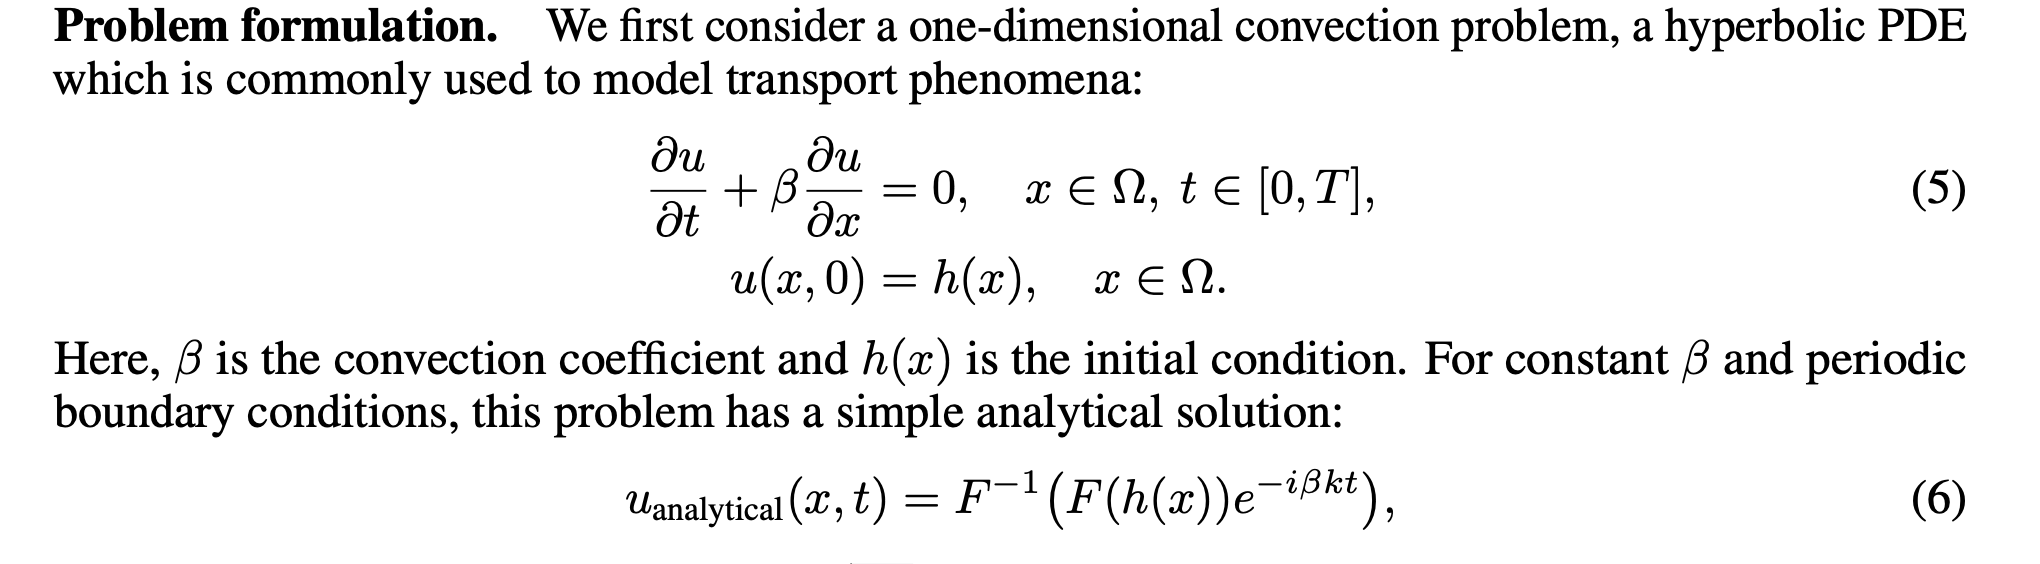

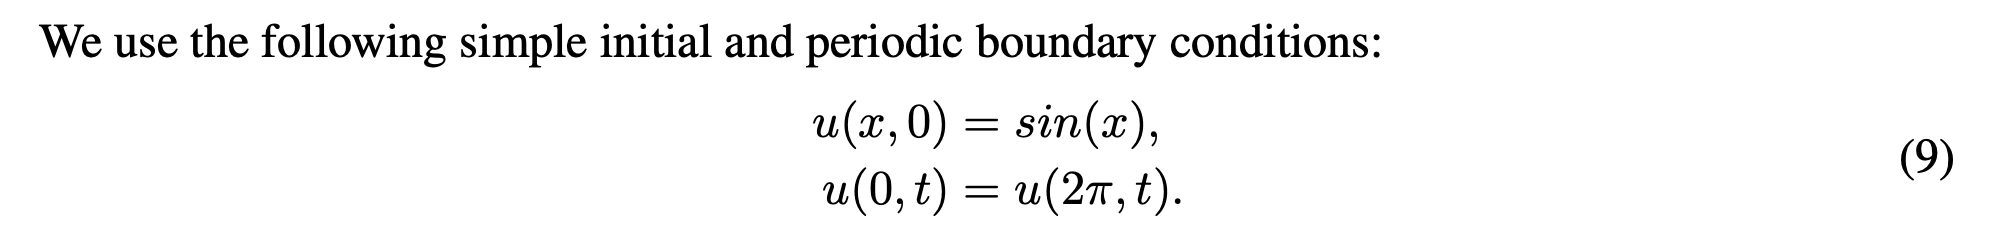

## Analytical solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rate = 5000
x = np.linspace(0, 2*np.pi, rate)
t = np.linspace(0, 1, rate)

x.shape, t.shape

((5000,), (5000,))

In [2]:
def h(x):
    return np.sin(x)

def analytical(x, t, beta):
    fft = np.fft.fft(h(x))
    freq = np.fft.fftfreq(len(fft), 1/rate)
    exp = np.exp(-1j*beta*freq*t) 
    
    return np.fft.ifft(fft*exp).real

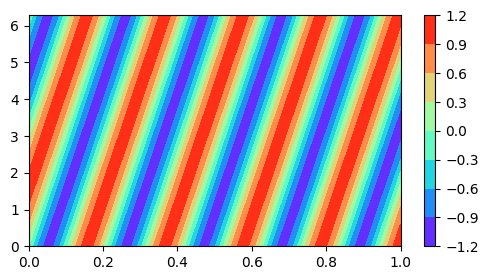

In [3]:
grid = np.meshgrid(x, t)
fig = plt.figure(figsize=(6,3))
plt.contourf(t, x, analytical(x=grid[0], t=grid[1], beta=30).T, cmap='rainbow')
plt.colorbar()
plt.show()

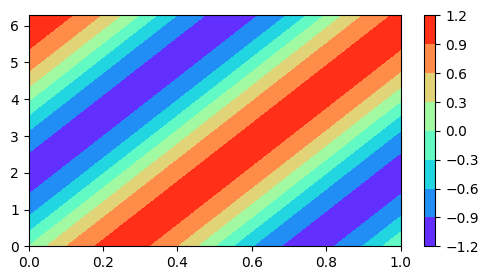

In [ ]:
fig = plt.figure(figsize=(6,3))
plt.contourf(t, x, analytical(x=grid[0], t=grid[1], beta=5), cmap='rainbow')
plt.colorbar()
plt.show()

## Dataset generation for FNO

In [3]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

/tmp/ipykernel_66348/3091149478.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
STEPS = 300
PRINT_EVERY = 30
SEED = 42

key = jax.random.PRNGKey(SEED)

2024-01-24 09:45:57.935046: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Подход 0: FNO overfit

Сперва, проверим, может ли нейросеть из граничных условий воспроизвести решение при константных $\beta$ и гран. условиях $\forall t \in [0, 1]$.

In [5]:
rate = 5000

a_data = np.tile(np.sin(x), (10, 1))
u_data = np.tile(np.array([analytical(x, i, 30) for i in np.linspace(0, 1, rate)]), (10, 1, 1))

print(a_data.shape, u_data.shape)

(10, 5000) (10, 5000, 5000)


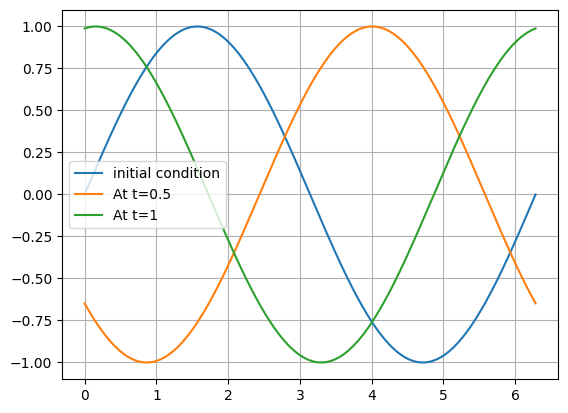

In [6]:
plt.plot(x, a_data[0], label="initial condition")
plt.plot(x, u_data[0][2500], label="At t=0.5")
plt.plot(x, u_data[0][-1], label="At t=1")
plt.legend()
plt.grid()

In [7]:
a_data = a_data[:, jnp.newaxis, :]
u_data = u_data[:, jnp.newaxis, :, :]
mesh = jnp.linspace(0, 2*jnp.pi, u_data.shape[-1])
a_data.shape, u_data.shape, mesh.shape

((10, 1, 5000), (10, 1, 5000, 5000), (5000,))

In [8]:
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u_data.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a_data, mesh_shape_corrected), axis=1)

mesh_shape_corrected.shape, a_with_mesh.shape

((10, 1, 5000), (10, 2, 5000))

In [9]:
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200] #fix me
train_y, test_y = u_data[:1000], u_data[1000:1200]

In [14]:
from FNOCore import FNO1d

fno = FNO1d(
    2,
    rate,
    16,
    64,
    jax.nn.relu,
    key=jax.random.PRNGKey(0),
)

In [15]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

In [16]:
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss

optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))

@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss

loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(1000)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

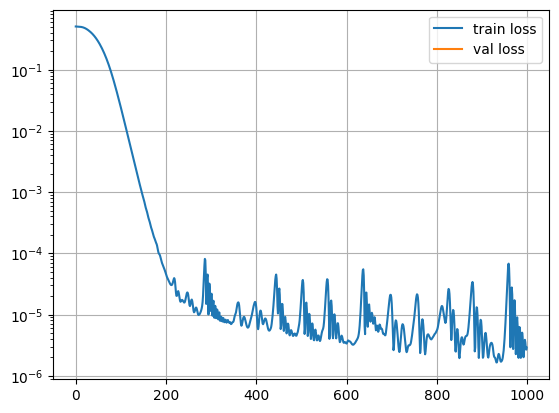

In [17]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

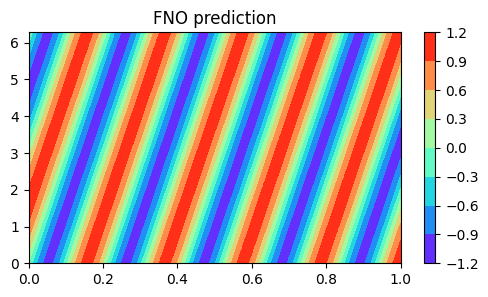

In [19]:
grid = np.meshgrid(x, t)
fig = plt.figure(figsize=(6,3))
plt.contourf(t, x, fno(train_x[1, :]).T, cmap='rainbow')
plt.title('FNO prediction')
plt.colorbar()
plt.show()

/tmp/ipykernel_66348/134517496.py:7: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(


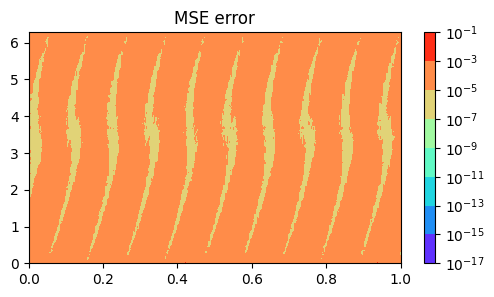

In [21]:
from matplotlib import cm, ticker

def mse(y_pred, y):
    return jnp.square(y_pred - y)

fig = plt.figure(figsize=(6, 3))
plt.contourf(
    t,
    x,
    jax.vmap(mse)(fno(train_x[1, :]), analytical(x=grid[0], t=grid[1], beta=30)).T,
    cmap="rainbow",
    locator=ticker.LogLocator(),
)
plt.title("MSE error")
plt.colorbar()
plt.show()

### Подход 1: positional embedding

Обычно, при обучении FNO задача ставится следующим образом – хотим решать уравнение при различных начальных/граничных условиях. В таком случае, датасет формируется из пар (condition, solution), где начальное условие сэмплируется из некоторого распределения. 

Нам же, хочется решать задачу с одним начальным условием, но для произвольного $\beta$. Тут возникает проблема – нейросеть из чего-то должна извлекать признаки. В нашем случае, к начальному условию нужно добавить инофрмацию о $\beta$.

Первая идея – применить подход, похожий на positional encoding в NLP. Здесь, очевидно, используется тот факт, что граничное условие у нас одно и фиксированное. Можно предположить, что модель на основе тренировочного набора научится отличать граничное условие от позиционного эмбеддинга.


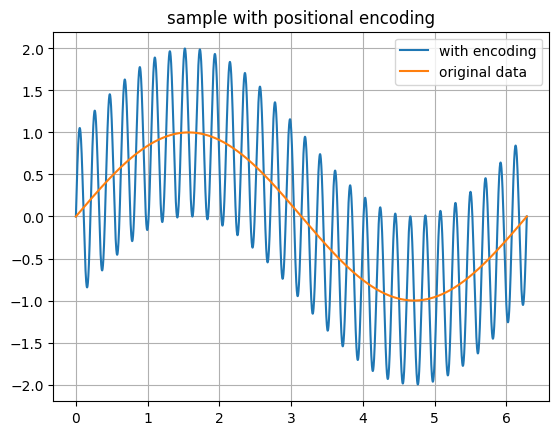

In [34]:
beta = 30
plt.plot(x, np.sin(x)+np.sin(beta*x), label="with encoding")
plt.plot(x, np.sin(x), label="original data")
plt.grid()
plt.title("sample with positional encoding")
plt.legend()

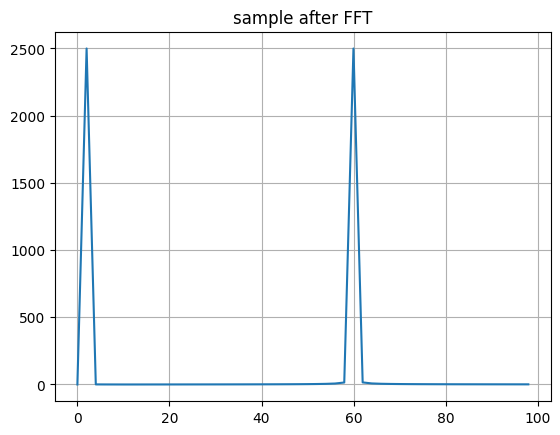

In [35]:
fft = np.fft.rfft(np.sin(x)+np.sin(beta*x))
freq = np.fft.rfftfreq(len(fft), 1/rate)
plt.plot(freq[:50], abs(fft)[:50])
plt.title("sample after FFT")
plt.grid()

#### Dataset generation

### Подход 2 – разные граничные условия

Здесь попробуем решить задачу с константным коэффициентом $\beta$, но с различными граничными условиями, как обычно это делается при работе с FNO. Здесь сперва нужно понять, каким образом генерировать синтетические данные, как должны выглядеть граничные условия и чем это все дело решать. 